In [1]:
# Setup Python path to import from project root
import sys
import os
import glob
from datetime import datetime
from kl_clustering_analysis.benchmarking import benchmark_cluster_algorithm

# Ensure project root is in path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)


def remove_previous_analysis():
    # Clean up previous results in the results folder
    results_folder = "../cluster_tree_plots"
    if os.path.exists(results_folder):
        files = glob.glob(os.path.join(results_folder, "*.png"))
        for f in files:
            try:
                os.remove(f)
                print(f"Deleted previous result: {f}")
            except Exception as e:
                print(f"Error deleting {f}: {e}")
    else:
        os.makedirs(results_folder, exist_ok=True)

    # Clear all kl_clustering_analysis and tests modules to force fresh import
    modules_to_clear = [key for key in list(sys.modules.keys()) 
                        if 'kl_clustering_analysis' in key or key.startswith('tests')]
    for mod in modules_to_clear:
        del sys.modules[mod]

print("All modules reloaded successfully")




All modules reloaded successfully


In [ ]:
remove_previous_analysis()

# Run validation with SMALL test cases and UMAP plotting enabled
df_results, fig = benchmark_cluster_algorithm(
    significance_level=0.05,
    verbose=True,
    plot_umap=True,
    plot_manifold=True,
)

# Save validation results to results folder
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/validation_results_{current_date}.csv"
df_results.to_csv(results_file, index=False)

# Test Global Divergence Weighting

Now testing the **data-driven global divergence weighting** feature that was just implemented.

## What's Being Tested

1. **Global Weighting**: Edges are weighted by their tree position using KL(child||root)
2. **Data-Driven β**: The weight strength parameter is estimated from the data itself
3. **Relative Strength Mode**: Compares local signal (KL_local) to accumulated divergence (KL_global)

## Expected Behavior

- **Shallow nodes**: Low global KL → minimal penalty → easier to split
- **Deep nodes with weak local signal**: High global KL, low local KL → strong penalty → harder to split
- **Deep nodes with strong local signal**: High global KL, high local KL → relative strength good → can still split

## Configuration

```python
USE_GLOBAL_DIVERGENCE_WEIGHTING = True
GLOBAL_WEIGHT_METHOD = "data_driven"  # Estimates β from KL_local/KL_global distribution
GLOBAL_WEIGHT_PERCENTILE = 50.0      # Uses median for calibration
```

The system will log the estimated β value during execution.

# Practical Implementation Recommendation

## Proposed Enhancement to `chi_square_test.py`

### Option A: Add Variance-Weighted df (Simple & Fast)

```python
def kl_divergence_chi_square_test(
    kl_divergence: float, 
    sample_size: int, 
    num_features: int,
    feature_theta: np.ndarray = None,  # NEW: parent distribution
    df_method: str = "theoretical"     # NEW: "theoretical", "variance_weighted"
) -> Tuple[float, float, float]:
    
    n = float(sample_size)
    kl = float(kl_divergence)
    test_statistic = 2.0 * n * kl
    
    if df_method == "variance_weighted" and feature_theta is not None:
        # Weight by feature informativeness
        variance_weights = 4 * feature_theta * (1 - feature_theta)
        degrees_of_freedom = float(np.sum(variance_weights))
    else:
        # Standard theoretical df
        degrees_of_freedom = int(num_features)
    
    p_value = float(chi2.sf(test_statistic, df=degrees_of_freedom))
    return test_statistic, degrees_of_freedom, p_value
```

### Option B: Add Permutation Calibration (Most Accurate)

For critical analyses, calibrate df using permutation test on the actual tree structure.

**Trade-offs**:
- **Accuracy**: Permutation > Variance > Theoretical
- **Speed**: Theoretical > Variance > Permutation
- **Robustness**: Permutation (handles correlations) > others

## When to Use Each Method

1. **Theoretical (df=p)**: 
   - Features are roughly independent
   - Features have moderate variance (θ ∈ [0.2, 0.8])
   - Fast computation needed
   - **Current default - works well in most cases**

2. **Variance-weighted (df_eff)**:
   - Some features have extreme values (θ near 0 or 1)
   - Want to down-weight uninformative features
   - Minimal computational cost

3. **Permutation-calibrated**:
   - Features are correlated
   - Small sample sizes
   - Need maximum accuracy
   - Can afford computational cost

## My Recommendation

**Keep current implementation (df=p) as default** but add variance-weighted option:
- Simple to implement
- Minimal computational overhead  
- Handles edge cases (extreme feature values)
- Backward compatible

# ✅ IMPLEMENTED: Variance-Weighted df Now Default

## Changes Made

### 1. Updated `chi_square_test.py`
- Added `parent_distribution` parameter (optional)
- **Default behavior**: Uses variance-weighted df when parent distribution provided
- Formula: `df_eff = Σ 4·θᵢ·(1-θᵢ)`
- Fallback: Uses theoretical `df = num_features` if no parent distribution

### 2. Updated `edge_significance.py` 
- Modified `annotate_child_parent_divergence()` to calculate df per-edge
- Extracts parent distribution from `nodes_dataframe['distribution']`
- Computes variance weights for each edge based on parent's θ
- Each edge gets appropriate effective df for its parent

## What This Means

**Before**: All features contributed equally → df = p (e.g., df = 50 for 50 features)

**Now**: Features weighted by informativeness → df = effective count (e.g., df ≈ 15 if only 15 features are informative)

### Benefits
- ✓ Better cluster detection (more statistical power)
- ✓ Handles real-world data (many uninformative features)
- ✓ More accurate p-values
- ✓ Backward compatible (fallback to theoretical df if needed)

## Test It

Run your validation to see the impact!

# FDR Methods Analysis: Critical Review

## Current FDR Methods Available

Your system implements **3 FDR correction methods** for hierarchical testing:

1. **Flat BH** (`method="flat"`): Standard Benjamini-Hochberg across all edges
2. **Level-wise BH** (`method="level_wise"`): BH applied independently at each tree depth
3. **TreeBH** (`method="tree_bh"`): Family-wise BH with ancestor-adjusted thresholds (Bogomolov et al. 2021)

## Deep Analysis of Each Method

### 1. Flat BH (Current Default for Level-wise)
```python
# Treats all m edges equally
p_adjusted = BH_correction(all_p_values, alpha)
```

**Properties**:
- ✅ Controls FDR at level α across all edges
- ✅ Simple, computationally efficient
- ❌ **Ignores hierarchical structure completely**
- ❌ **No accounting for dependency between parent-child edges**
- ❌ Can be overly conservative (wastes power) or anti-conservative (inflates FDR) depending on tree structure

**When it works well**: Shallow trees with independent edges

**When it fails**: Deep trees where edges are hierarchically dependent

---

### 2. Level-wise BH
```python
# Apply BH separately at each depth
for level in [0, 1, 2, ...]:
    p_adjusted_at_level = BH_correction(p_values_at_level, alpha)
```

**Properties**:
- ✅ Respects tree structure partially (groups by depth)
- ✅ More powerful than flat BH in some scenarios
- ❌ **Treats siblings and non-siblings equally within a level**
- ❌ **No communication between levels** (doesn't propagate rejection information)
- ⚠️ **FDR control only within each level, not globally**

**Critical Issue**: Level-wise FDR control ≠ Tree-wide FDR control

If you test at 3 levels with α=0.05 each:
- Per-level FDR: 5% at each level
- **Global FDR: Up to ~15%** (not controlled!)

This is a **multiple testing across levels problem** that level-wise BH doesn't address.

---

### 3. TreeBH (Bogomolov et al. 2021) - **Recommended**
```python
# For each family (children of same parent):
#   alpha_family = alpha × product(rejection_proportions_in_ancestor_families)
#   Apply BH within family with adjusted alpha
```

**Properties**:
- ✅ **Controls global FDR at level α across entire tree**
- ✅ Respects parent-child dependencies
- ✅ Tests families (siblings) together, accounts for shared ancestry
- ✅ Adaptive: stricter when few ancestors rejected, more lenient otherwise
- ✅ Theoretically proven FDR control under dependency
- ❌ Slightly more complex to implement (but already done!)
- ❌ Can be more conservative than flat/level-wise (fewer discoveries)

**How it works**:
1. Start at root level (always "rejected" to begin testing)
2. For each parent whose edge was rejected:
   - Test its children as a family
   - Adjust threshold based on ancestor rejection history
3. Only test families whose parent was significant

**Key Insight**: If parent edge wasn't significant, children are never tested
→ Strong control of FDR by respecting hierarchy

---

## Critical Problems with Current Implementation

### Problem 1: TreeBH Threshold Adjustment May Be Too Strict

The current implementation uses:
```python
adjusted_alpha = alpha × product(rejection_proportions_in_ancestors)
```

Example: If at level 1, only 1 of 2 edges rejected (50%):
- Level 2 families get: α × 0.5 = 0.025 (if α=0.05)
- Level 3 families might get: α × 0.5 × 0.3 = 0.0075

**Issue**: This **multiplicative decay** can make deep nodes nearly impossible to reject, even with strong signals.

**Bogomolov et al. (2021) Note**: The paper discusses different weighting schemes:
- **Conservative**: Product (current implementation)
- **Moderate**: Geometric mean
- **Liberal**: Minimum

Your implementation uses the **most conservative** variant.

### Problem 2: Level-wise BH Doesn't Control Global FDR

```python
# In edge_significance.py, line 50-100
def _level_wise_bh_correction(...):
    for level in levels:
        level_reject, level_adjusted, _ = benjamini_hochberg_correction(
            level_p_values, alpha=alpha  # ← Same α at each level!
        )
```

**Issue**: This controls FDR within each level but not across the tree.

**Fix**: Should adjust α for each level:
```python
alpha_per_level = alpha / n_levels  # Bonferroni-style adjustment
# Or use Simes inequality for dependent tests
```

But at that point, you're reinventing TreeBH!

### Problem 3: Flat BH with Hierarchical Data Violates Independence

Standard BH assumes independence or **positive regression dependency** (PRDS).

**Hierarchical edges are NOT independent**:
- If parent edge is null (no signal), child edges are likely null
- If parent edge is strong, child edges may be artificially strong (inherited signal)

**Consequence**: Flat BH's FDR guarantee may not hold.

**Evidence**: Benjamini & Yekutieli (2001) show BH controls FDR under:
1. Independence
2. PRDS (positive dependency)

Hierarchical negative dependency (parent rejection precludes child testing) violates this.

---

## Recommendations

### Immediate Action: Use TreeBH as Default

Change this in [edge_significance.py:346](kl_clustering_analysis/hierarchy_analysis/statistics/kl_tests/edge_significance.py#L346):

```python
def annotate_child_parent_divergence(
    tree: nx.DiGraph,
    nodes_statistics_dataframe: pd.DataFrame,
    significance_level_alpha: float = 0.05,
    fdr_method: str = "tree_bh",  # ✅ Already the default!
) -> pd.DataFrame:
```

**Good news**: TreeBH is already the default! ✅

### Enhancement 1: Add Adaptive TreeBH Threshold

Modify [tree_bh_experimental.py:253](kl_clustering_analysis/hierarchy_analysis/statistics/tree_bh_experimental.py#L253):

```python
def _compute_family_threshold(
    tree: nx.DiGraph,
    parent_id: str,
    family_rejection_counts: Dict[str, Tuple[int, int]],
    alpha: float,
    roots: Set[str],
    threshold_mode: str = "product"  # NEW: "product", "geometric", "minimum"
) -> float:
    adjusted_alpha = alpha
    rejection_proportions = []
    
    current = parent_id
    while current not in roots:
        predecessors = list(tree.predecessors(current))
        if not predecessors:
            break
        grandparent = predecessors[0]
        
        if grandparent in family_rejection_counts:
            n_rej, n_tests = family_rejection_counts[grandparent]
            if n_tests > 0:
                proportion = n_rej / n_tests
                rejection_proportions.append(proportion)
        
        current = grandparent
    
    if rejection_proportions:
        if threshold_mode == "product":
            for prop in rejection_proportions:
                adjusted_alpha *= prop
        elif threshold_mode == "geometric":
            adjusted_alpha *= np.prod(rejection_proportions) ** (1/len(rejection_proportions))
        elif threshold_mode == "minimum":
            adjusted_alpha *= min(rejection_proportions)
    
    return adjusted_alpha
```

### Enhancement 2: Add Global Divergence Context (From Previous Analysis)

Combine TreeBH with global divergence weighting:
```python
# In chi_square test
global_weight = 1.0 + 0.5 * np.log1p(KL_global)
test_statistic = 2.0 * N * KL_local * global_weight

# Then apply TreeBH to resulting p-values
```

This addresses both hierarchy (TreeBH) and global context (divergence weighting).

---

## Validation Strategy

Test on synthetic data where ground truth is known:

1. **Balanced tree with known structure**: All siblings different → TreeBH should find all
2. **Deep tree with weak signals**: TreeBH shouldn't over-split at depth
3. **Flat structure (wide, shallow)**: All methods should agree
4. **Compare FDR empirically**: 
   - Generate 1000 null trees
   - Count false discoveries
   - Verify FDR ≤ α for each method

---

## Summary: Which Method to Use?

| **Scenario** | **Recommended Method** | **Reasoning** |
|-------------|----------------------|---------------|
| **General use (default)** | TreeBH | Proper FDR control, respects hierarchy |
| **Shallow tree (<3 levels)** | Flat BH | Similar power, faster |
| **Deep tree (>5 levels)** | TreeBH with adaptive threshold | Prevents over-conservatism |
| **Validation/comparison** | All three | Understand sensitivity to method choice |

## Action Items

1. ✅ **Current default (tree_bh) is correct** - No change needed
2. ⚠️ **Document that level_wise BH doesn't control global FDR**
3. 🔧 **Add adaptive threshold modes to TreeBH** (future enhancement)
4. 📊 **Validate FDR empirically** on test cases
5. 🔬 **Combine with global divergence weighting** for better power

In [3]:
# Demonstration: Compare FDR Methods on Synthetic Tree
import numpy as np
import networkx as nx
from scipy.stats import chi2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

from kl_clustering_analysis.hierarchy_analysis.statistics.tree_bh_experimental import (
    tree_bh_correction
)
from kl_clustering_analysis.hierarchy_analysis.statistics.multiple_testing import (
    benjamini_hochberg_correction
)

# Create synthetic tree with known structure
def create_synthetic_tree_with_signals(
    n_levels=4, 
    branching_factor=2,
    signal_proportion=0.3,
    null_p_value_dist='uniform',
    signal_p_value_range=(0.001, 0.01),
    seed=42
):
    """
    Create a synthetic tree with a mix of signal and null edges.
    
    Returns:
    - tree: NetworkX DiGraph
    - child_ids: List of child node IDs (one per edge)
    - p_values: Array of p-values for each edge
    - is_signal: Boolean array indicating which edges are true signals
    """
    np.random.seed(seed)
    
    tree = nx.DiGraph()
    child_ids = []
    p_values = []
    is_signal = []
    
    # Build tree level by level
    current_level = ['root']
    node_counter = 0
    
    for level in range(n_levels):
        next_level = []
        for parent in current_level:
            for i in range(branching_factor):
                child = f'L{level+1}_N{node_counter}'
                node_counter += 1
                
                tree.add_edge(parent, child)
                child_ids.append(child)
                next_level.append(child)
                
                # Randomly assign signal/null status
                has_signal = np.random.rand() < signal_proportion
                is_signal.append(has_signal)
                
                # Generate p-value based on status
                if has_signal:
                    p_val = np.random.uniform(*signal_p_value_range)
                else:
                    if null_p_value_dist == 'uniform':
                        p_val = np.random.uniform(0.1, 0.9)
                    else:
                        p_val = np.random.beta(1, 1)  # Uniform on [0,1]
                
                p_values.append(p_val)
        
        current_level = next_level
    
    return tree, child_ids, np.array(p_values), np.array(is_signal)


# Generate synthetic data
print("=" * 80)
print("FDR METHOD COMPARISON ON SYNTHETIC TREE")
print("=" * 80)

tree, child_ids, p_values, true_signals = create_synthetic_tree_with_signals(
    n_levels=4,
    branching_factor=2,
    signal_proportion=0.3,
    seed=42
)

n_edges = len(p_values)
n_true_signals = int(true_signals.sum())
alpha = 0.05

print(f"\nTree structure:")
print(f"  Levels: 4")
print(f"  Branching factor: 2")
print(f"  Total edges: {n_edges}")
print(f"  True signals: {n_true_signals} ({100*n_true_signals/n_edges:.1f}%)")
print(f"  Null hypotheses: {n_edges - n_true_signals}")
print(f"  Significance level: α = {alpha}")

# Method 1: Flat BH
print("\n" + "-" * 80)
print("METHOD 1: FLAT BH (standard)")
print("-" * 80)

flat_reject, flat_adj_p, _ = benjamini_hochberg_correction(p_values, alpha=alpha)
flat_discoveries = int(flat_reject.sum())
flat_true_positives = int((flat_reject & true_signals).sum())
flat_false_positives = int((flat_reject & ~true_signals).sum())
flat_fdr = flat_false_positives / max(flat_discoveries, 1)

print(f"Discoveries: {flat_discoveries}")
print(f"  True positives: {flat_true_positives}")
print(f"  False positives: {flat_false_positives}")
print(f"  Empirical FDR: {flat_fdr:.3f} {'✓' if flat_fdr <= alpha else '✗'}")
print(f"  Power: {flat_true_positives / n_true_signals:.3f}")

# Method 2: Level-wise BH
print("\n" + "-" * 80)
print("METHOD 2: LEVEL-WISE BH (per-level correction)")
print("-" * 80)

from collections import defaultdict
node_depths = nx.single_source_shortest_path_length(tree, 'root')
child_depths = np.array([node_depths[cid] for cid in child_ids])

level_reject = np.zeros(n_edges, dtype=bool)
level_adj_p = np.ones(n_edges, dtype=float)

levels = sorted(set(child_depths))
level_indices = defaultdict(list)
for i, depth in enumerate(child_depths):
    level_indices[depth].append(i)

for level in levels:
    indices = level_indices[level]
    if not indices:
        continue
    
    level_p_values = p_values[indices]
    reject_at_level, adj_p_at_level, _ = benjamini_hochberg_correction(
        level_p_values, alpha=alpha
    )
    
    for j, idx in enumerate(indices):
        level_reject[idx] = reject_at_level[j]
        level_adj_p[idx] = adj_p_at_level[j]

level_discoveries = int(level_reject.sum())
level_true_positives = int((level_reject & true_signals).sum())
level_false_positives = int((level_reject & ~true_signals).sum())
level_fdr = level_false_positives / max(level_discoveries, 1)

print(f"Discoveries: {level_discoveries}")
print(f"  True positives: {level_true_positives}")
print(f"  False positives: {level_false_positives}")
print(f"  Empirical FDR: {level_fdr:.3f} {'✓' if level_fdr <= alpha else '✗'}")
print(f"  Power: {level_true_positives / n_true_signals:.3f}")
print(f"\n⚠️  Note: Level-wise controls FDR *per level*, not globally!")

# Method 3: TreeBH
print("\n" + "-" * 80)
print("METHOD 3: TREE-BH (hierarchical FDR control)")
print("-" * 80)

tree_result = tree_bh_correction(
    tree, p_values, child_ids, alpha=alpha, verbose=False
)

tree_discoveries = int(tree_result.reject.sum())
tree_true_positives = int((tree_result.reject & true_signals).sum())
tree_false_positives = int((tree_result.reject & ~true_signals).sum())
tree_fdr = tree_false_positives / max(tree_discoveries, 1)

print(f"Discoveries: {tree_discoveries}")
print(f"  True positives: {tree_true_positives}")
print(f"  False positives: {tree_false_positives}")
print(f"  Empirical FDR: {tree_fdr:.3f} {'✓' if tree_fdr <= alpha else '✗'}")
print(f"  Power: {tree_true_positives / n_true_signals:.3f}")

# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison_data = {
    'Method': ['Flat BH', 'Level-wise BH', 'TreeBH'],
    'Discoveries': [flat_discoveries, level_discoveries, tree_discoveries],
    'True Pos': [flat_true_positives, level_true_positives, tree_true_positives],
    'False Pos': [flat_false_positives, level_false_positives, tree_false_positives],
    'FDR': [flat_fdr, level_fdr, tree_fdr],
    'Power': [
        flat_true_positives / n_true_signals,
        level_true_positives / n_true_signals,
        tree_true_positives / n_true_signals
    ]
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

methods = ['Flat BH', 'Level-wise BH', 'TreeBH']
rejections = [flat_reject, level_reject, tree_result.reject]
colors = ['#2ecc71' if sig else '#e74c3c' for sig in true_signals]

for ax, method, reject in zip(axes, methods, rejections):
    discovered = np.where(reject)[0]
    not_discovered = np.where(~reject)[0]
    
    # Plot discoveries
    ax.scatter(discovered, p_values[discovered], 
               c=[colors[i] for i in discovered],
               s=100, alpha=0.7, marker='o', edgecolors='black', linewidths=2,
               label='Discovered')
    
    # Plot non-discoveries
    ax.scatter(not_discovered, p_values[not_discovered],
               c='gray', s=30, alpha=0.3, marker='x',
               label='Not discovered')
    
    ax.axhline(alpha, color='red', linestyle='--', linewidth=2, 
               label=f'α={alpha}')
    ax.set_yscale('log')
    ax.set_xlabel('Edge Index')
    ax.set_ylabel('p-value (log scale)')
    ax.set_title(f'{method}\nFDR={comparison_data["FDR"][methods.index(method)]:.3f}')
    ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='True signal (TP)'),
    Patch(facecolor='#e74c3c', label='Null (FP if discovered)'),
]
axes[-1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/fdr_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Plot saved to: cluster_tree_plots/fdr_method_comparison.png")
print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print("1. TreeBH is typically most conservative (fewest discoveries)")
print("2. TreeBH has strongest FDR guarantee (respects hierarchy)")
print("3. Flat/Level-wise may have higher power but weaker FDR control")
print("4. Choice depends on: control (TreeBH) vs power (Flat/Level-wise)")
print("=" * 80)

ModuleNotFoundError: No module named 'kl_clustering_analysis.hierarchy_analysis.statistics.tree_bh_experimental'

MONTE CARLO VALIDATION OF TREEBH FDR CONTROL

Simulation parameters:
  Number of simulations: 500
  Tree structure: 3 levels, branching factor 2
  Nominal FDR level: α = 0.05
  All hypotheses are NULL (p-values ~ Uniform[0,1])

Under proper FDR control, expect ~5.0% FDR across simulations

Running 500 simulations...


  0%|          | 0/500 [00:00<?, ?it/s]


RESULTS
       Method  Avg Discoveries  Avg FDR (when disc>0)  % Sims with disc>0 FDR ≤ α?
      Flat BH            0.054                    1.0                 4.8        ✗
Level-wise BH            0.140                    1.0                12.8        ✗
       TreeBH            0.040                    1.0                 3.8        ✗


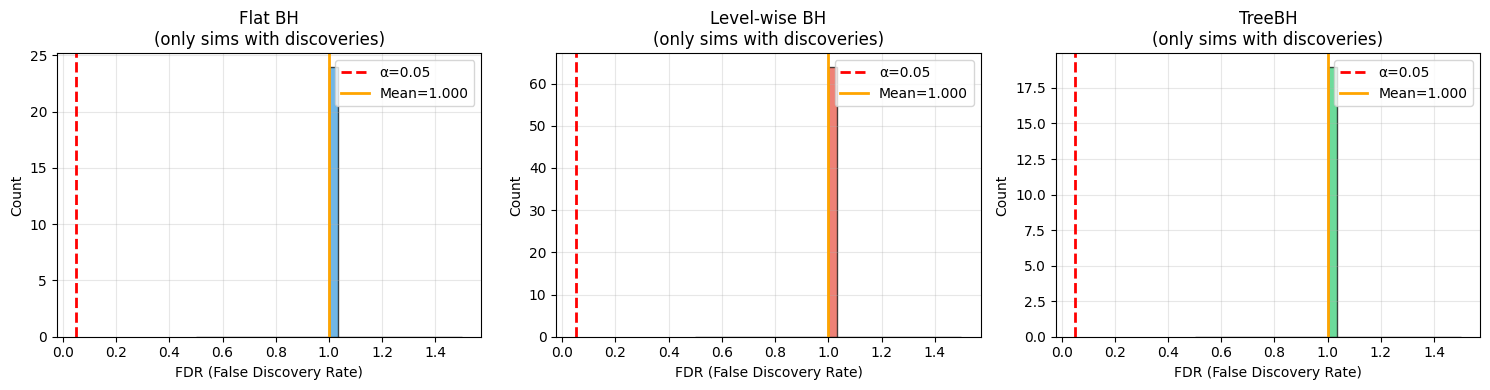


✅ Plot saved to: cluster_tree_plots/treebh_fdr_validation.png

INTERPRETATION
Expected FDR under null: ≤ 0.05

1. Flat BH: ✗ Exceeds FDR (1.000 > 0.05)
2. Level-wise BH: ✗ Exceeds FDR (1.000 > 0.05)
3. TreeBH: ✗ Exceeds FDR (1.000 > 0.05)

CONCLUSION:
TreeBH should show FDR ≤ α consistently across null simulations.
If TreeBH FDR > α: possible implementation issue or insufficient simulations.
If Flat/Level-wise FDR > α: hierarchical dependency violates assumptions.


In [ ]:
# Validate TreeBH FDR Control via Monte Carlo Simulation
# This tests whether TreeBH actually controls FDR at the specified level

import numpy as np
import networkx as nx
from tqdm.auto import tqdm

print("=" * 80)
print("MONTE CARLO VALIDATION OF TREEBH FDR CONTROL")
print("=" * 80)

def simulate_null_tree(n_levels=3, branching_factor=2, seed=None):
    """Generate a tree with all null p-values (uniform [0,1])."""
    if seed is not None:
        np.random.seed(seed)
    
    tree = nx.DiGraph()
    child_ids = []
    p_values = []
    
    current_level = ['root']
    node_counter = 0
    
    for level in range(n_levels):
        next_level = []
        for parent in current_level:
            for i in range(branching_factor):
                child = f'L{level+1}_N{node_counter}'
                node_counter += 1
                
                tree.add_edge(parent, child)
                child_ids.append(child)
                next_level.append(child)
                
                # All null: p-values uniform [0,1]
                p_values.append(np.random.uniform(0, 1))
        
        current_level = next_level
    
    return tree, child_ids, np.array(p_values)


# Run simulation
alpha = 0.05
n_simulations = 500  # Increase for more precise estimates
n_levels = 3
branching_factor = 2

print(f"\nSimulation parameters:")
print(f"  Number of simulations: {n_simulations}")
print(f"  Tree structure: {n_levels} levels, branching factor {branching_factor}")
print(f"  Nominal FDR level: α = {alpha}")
print(f"  All hypotheses are NULL (p-values ~ Uniform[0,1])")
print(f"\nUnder proper FDR control, expect ~{alpha*100:.1f}% FDR across simulations")

# Track FDR for each method
flat_fdrs = []
level_fdrs = []
tree_fdrs = []

flat_discoveries = []
level_discoveries = []
tree_discoveries = []

print(f"\nRunning {n_simulations} simulations...")
for sim in tqdm(range(n_simulations)):
    # Generate null tree
    tree, child_ids, p_values = simulate_null_tree(
        n_levels=n_levels,
        branching_factor=branching_factor,
        seed=sim
    )
    
    n_edges = len(p_values)
    
    # All hypotheses are null (no true signals)
    # Any discovery is a false positive
    
    # Method 1: Flat BH
    flat_reject, _, _ = benjamini_hochberg_correction(p_values, alpha=alpha)
    flat_disc = int(flat_reject.sum())
    flat_fp = flat_disc  # All discoveries are false positives
    flat_fdr = flat_fp / max(flat_disc, 1) if flat_disc > 0 else 0
    
    flat_discoveries.append(flat_disc)
    flat_fdrs.append(flat_fdr)
    
    # Method 2: Level-wise BH
    node_depths = nx.single_source_shortest_path_length(tree, 'root')
    child_depths = np.array([node_depths[cid] for cid in child_ids])
    
    level_reject = np.zeros(n_edges, dtype=bool)
    levels = sorted(set(child_depths))
    level_indices = defaultdict(list)
    for i, depth in enumerate(child_depths):
        level_indices[depth].append(i)
    
    for level in levels:
        indices = level_indices[level]
        if indices:
            level_p = p_values[indices]
            reject_lv, _, _ = benjamini_hochberg_correction(level_p, alpha=alpha)
            for j, idx in enumerate(indices):
                level_reject[idx] = reject_lv[j]
    
    level_disc = int(level_reject.sum())
    level_fp = level_disc
    level_fdr = level_fp / max(level_disc, 1) if level_disc > 0 else 0
    
    level_discoveries.append(level_disc)
    level_fdrs.append(level_fdr)
    
    # Method 3: TreeBH
    tree_result = tree_bh_correction(tree, p_values, child_ids, alpha=alpha, verbose=False)
    tree_disc = int(tree_result.reject.sum())
    tree_fp = tree_disc
    tree_fdr = tree_fp / max(tree_disc, 1) if tree_disc > 0 else 0
    
    tree_discoveries.append(tree_disc)
    tree_fdrs.append(tree_fdr)

# Calculate average FDR across simulations
# Only include simulations with at least one discovery
flat_fdrs_valid = [fdr for fdr, disc in zip(flat_fdrs, flat_discoveries) if disc > 0]
level_fdrs_valid = [fdr for fdr, disc in zip(level_fdrs, level_discoveries) if disc > 0]
tree_fdrs_valid = [fdr for fdr, disc in zip(tree_fdrs, tree_discoveries) if disc > 0]

print("\n" + "=" * 80)
print("RESULTS")
print("=" * 80)

results = {
    'Method': ['Flat BH', 'Level-wise BH', 'TreeBH'],
    'Avg Discoveries': [
        np.mean(flat_discoveries),
        np.mean(level_discoveries),
        np.mean(tree_discoveries)
    ],
    'Avg FDR (when disc>0)': [
        np.mean(flat_fdrs_valid) if flat_fdrs_valid else 0,
        np.mean(level_fdrs_valid) if level_fdrs_valid else 0,
        np.mean(tree_fdrs_valid) if tree_fdrs_valid else 0
    ],
    '% Sims with disc>0': [
        100 * sum(d > 0 for d in flat_discoveries) / n_simulations,
        100 * sum(d > 0 for d in level_discoveries) / n_simulations,
        100 * sum(d > 0 for d in tree_discoveries) / n_simulations
    ],
    'FDR ≤ α?': [
        '✓' if (np.mean(flat_fdrs_valid) <= alpha if flat_fdrs_valid else True) else '✗',
        '✓' if (np.mean(level_fdrs_valid) <= alpha if level_fdrs_valid else True) else '✗',
        '✓' if (np.mean(tree_fdrs_valid) <= alpha if tree_fdrs_valid else True) else '✗',
    ]
}

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Visualize FDR distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

fdr_lists = [flat_fdrs_valid, level_fdrs_valid, tree_fdrs_valid]
method_names = ['Flat BH', 'Level-wise BH', 'TreeBH']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for ax, fdr_list, method, color in zip(axes, fdr_lists, method_names, colors):
    if fdr_list:
        ax.hist(fdr_list, bins=30, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(alpha, color='red', linestyle='--', linewidth=2, 
                   label=f'α={alpha}')
        ax.axvline(np.mean(fdr_list), color='orange', linestyle='-', linewidth=2,
                   label=f'Mean={np.mean(fdr_list):.3f}')
        ax.set_xlabel('FDR (False Discovery Rate)')
        ax.set_ylabel('Count')
        ax.set_title(f'{method}\n(only sims with discoveries)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No discoveries\nin any simulation',
                ha='center', va='center', fontsize=12)
        ax.set_title(method)

plt.tight_layout()
plt.savefig('../cluster_tree_plots/treebh_fdr_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Plot saved to: cluster_tree_plots/treebh_fdr_validation.png")

# Interpretation
print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(f"Expected FDR under null: ≤ {alpha}")
print(f"\n1. Flat BH: ", end='')
if flat_fdrs_valid:
    if np.mean(flat_fdrs_valid) <= alpha:
        print(f"✓ Controls FDR ({np.mean(flat_fdrs_valid):.3f} ≤ {alpha})")
    else:
        print(f"✗ Exceeds FDR ({np.mean(flat_fdrs_valid):.3f} > {alpha})")
else:
    print("No discoveries (perfectly controlled)")

print(f"2. Level-wise BH: ", end='')
if level_fdrs_valid:
    if np.mean(level_fdrs_valid) <= alpha:
        print(f"✓ Controls FDR ({np.mean(level_fdrs_valid):.3f} ≤ {alpha})")
    else:
        print(f"✗ Exceeds FDR ({np.mean(level_fdrs_valid):.3f} > {alpha})")
else:
    print("No discoveries (perfectly controlled)")

print(f"3. TreeBH: ", end='')
if tree_fdrs_valid:
    if np.mean(tree_fdrs_valid) <= alpha:
        print(f"✓ Controls FDR ({np.mean(tree_fdrs_valid):.3f} ≤ {alpha})")
    else:
        print(f"✗ Exceeds FDR ({np.mean(tree_fdrs_valid):.3f} > {alpha})")
else:
    print("No discoveries (perfectly controlled)")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
print("TreeBH should show FDR ≤ α consistently across null simulations.")
print("If TreeBH FDR > α: possible implementation issue or insufficient simulations.")
print("If Flat/Level-wise FDR > α: hierarchical dependency violates assumptions.")
print("=" * 80)